In [6]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch_geometric.utils import to_networkx, negative_sampling, to_dense_adj
from torch_geometric.datasets import KarateClub
from torch_cluster import random_walk

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [7]:
data = KarateClub()[0]

In [8]:
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

In [9]:
data.x = torch.arange(data.num_nodes)

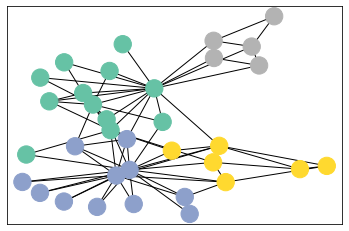

In [10]:
G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=data.y, cmap="Set2")

In [11]:
class Node2vecData(Dataset):
    
    def __init__(self, data, walk_length=2, num_walks_per_nodes=100):
        
        self.num_walks_per_nodes = num_walks_per_nodes
        
        self.walk_length = walk_length
        
        self.x = data.x
        
        self.edge_index = data.edge_index
        
        self.adj = to_dense_adj(self.edge_index).squeeze() + torch.eye(len(data.x))
        
    def __len__(self): 
        return len(self.x) * self.num_walks_per_nodes
    
    def sample_pos(self, x):
        """Positive walks"""
        
        row, col = self.edge_index # [2, num_edget]
                
        walk = random_walk(row, col, x, walk_length=self.walk_length, p=0.25, q=0.5)
                
        return walk.squeeze() # [walk_lengh,]
    
    def sample_neg(self, x):
        """Negative walks: random sampling"""
        
        negs = self.adj[x.squeeze()] == 0
                
        all_negs = self.x[negs]
        
        rand_idx = torch.randint(low=0, high=len(all_negs), size=(self.walk_length,))
                        
        return torch.cat([x, all_negs[rand_idx]]).squeeze() # [walk_lengh,]
    
    def __getitem__(self, idx):
        
        x = idx % len(self.x)
        
        x = torch.LongTensor([x]).view(1)
        
        # sample positives
        pos = self.sample_pos(x)
        
        # sample negatives
        neg = self.sample_neg(x)
                
        return pos, neg

In [12]:
train_loader = DataLoader(Node2vecData(data, 3), batch_size=256, num_workers=15)

In [13]:
next(iter(train_loader))

[tensor([[ 0, 11,  0, 19],
         [ 1, 13,  1, 30],
         [ 2,  3,  7,  0],
         ...,
         [15, 32, 15, 32],
         [16,  5, 16,  5],
         [17,  0,  3,  0]]),
 tensor([[ 0, 33, 16,  9],
         [ 1, 11, 23,  6],
         [ 2,  4,  5, 20],
         ...,
         [15, 30,  3,  8],
         [16, 21, 30,  2],
         [17, 29, 16,  9]])]

In [14]:
# ref: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html

class Node2V(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):
        
        super().__init__()
        
        self.embedding_dim = embedding_dim
        
        self.encoder = nn.Embedding(num_nodes, embedding_dim)
        
    def get_embeddings(self):
        
        return self.encoder.weight.data
    
    def encode(self, u):
        
        """embedding lookup encoder"""
        
        return self.encoder(u)
    
    def compute_loss(self, pos, neg):
        
        # word2vec negative sampling loss
        
        ### Positive
        
        h = self.encode(pos) # [batch_size, walk_length + 1, dim]
        
        h_start = h[:, 0, :].unsqueeze(1) # [batch_size, 1, dim]
        
        h_rest = h[:, 1:, :] # [batch_size, walk_length, dim]
        
        dot_prod = h_rest @ h_start.transpose(1, 2) # [batch_size, walk_length, 1]
        
        dot_prod = torch.sigmoid(dot_prod).view(-1) # flatten [batch_size * walk_length]
        
        pos_label = torch.ones_like(dot_prod) # [batch_size * walk_length]
        
        pos_loss = F.binary_cross_entropy(dot_prod, pos_label) 
        
        # bce(p, y) = - [y log p + (1-y) log (1-p)] => bce(p, y_pos) = - y_pos log p = - log p
        
        # pos_loss = - torch.log(dot_prod).mean()
        
        ### Negative
        
        h = self.encode(neg) # [batch_size, walk_length + 1, dim]
        
        h_start = h[:, 0, :].unsqueeze(1) # [batch_size, 1, dim]
        
        h_rest = h[:, 1:, :] # [batch_size, walk_length, dim]
        
        dot_prod = h_rest @ h_start.transpose(1, 2) # [batch_size, walk_length, 1]
        
        dot_prod = torch.sigmoid(dot_prod).view(-1) # flatten [batch_size * walk_length]
        
        neg_label = torch.zeros_like(dot_prod) # [batch_size * walk_length]
        
        neg_loss = F.binary_cross_entropy(dot_prod, neg_label)
        
        # bce(p, y) = - [y log p + (1-y) log (1-p)] => bce(p, y_neg) = - (1 - y_pos) log (1-p) = - log (1-p)
        
        # neg_loss = - torch.log(1 - dot_prod).mean()
        
        ### total loss
        
        return pos_loss + neg_loss
    
    def visualize(self):
        
        """visulize embeddings with PCA"""
    
        node_embeddings = self.get_embeddings()

        node_cmp = PCA(n_components=2).fit_transform(node_embeddings)

        y = data.y.numpy()

        plt.scatter(node_cmp[:, 0], node_cmp[:, 1], s=140, c=y, cmap="Set2")

        plt.show()
    
    def train_model(self, dataloader, n_epochs, opt):
        
        """train model given dataloader, n_epochs and opt"""
                        
        for i in tqdm(range(n_epochs)):
        
            for pos, neg in dataloader:

                loss = self.compute_loss(pos, neg)

                loss.backward()

                opt.step()
                
                opt.zero_grad()
            
            if i % 25 == 0:
                
                print(f'epoch={i}')
                
                self.visualize()

In [15]:
model = Node2V(data.num_nodes, 16)

opt = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.0001)

  0%|          | 0/101 [00:00<?, ?it/s]

epoch=0


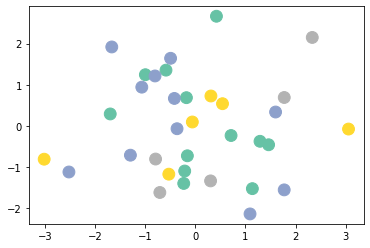

 25%|██▍       | 25/101 [00:13<00:42,  1.77it/s]

epoch=25


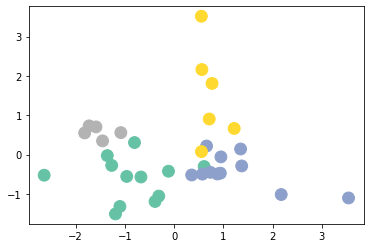

 50%|████▉     | 50/101 [00:26<00:27,  1.88it/s]

epoch=50


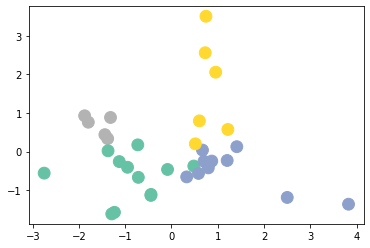

 74%|███████▍  | 75/101 [00:39<00:13,  1.88it/s]

epoch=75


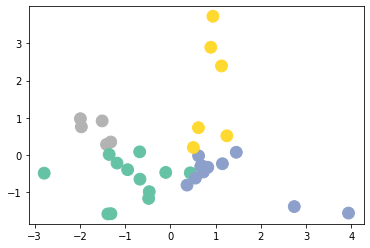

 99%|█████████▉| 100/101 [00:52<00:00,  1.97it/s]

epoch=100


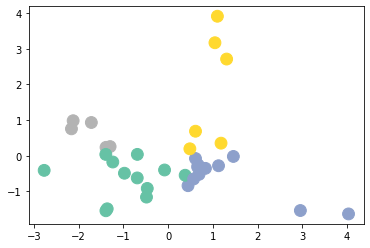

100%|██████████| 101/101 [00:52<00:00,  1.91it/s]


In [16]:
model.train_model(train_loader, 101, opt)

### Node2vec with pyG

In [ ]:
from torch_geometric.nn import Node2Vec

In [ ]:
node2vec = Node2Vec(edge_index=data.edge_index, embedding_dim=16, walk_length=3, context_size=3, walks_per_node=5)

opt_2 = torch.optim.Adam(node2vec.parameters())

In [ ]:
n2v_loader = node2vec.loader(batch_size=2, num_workers=5)

In [ ]:
pos, neg = next(iter(n2v_loader))

# pos and of shape [walks_per_node * batch_size]

In [ ]:
print(pos)

In [ ]:
# loss computation

loss = node2vec.loss(pos, neg)

print(loss)

# optimized with SGD or variant